In [1]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract, desc, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Save references to each table
tbl_measurement = Base.classes['measurement']
tbl_station = Base.classes['station']

In [9]:
# creating inspectior for columns generation
inspector = inspect(engine)
# Printing table metadata
for table in tables:
    print("\n")
    print('-' * 12)
    print(f"table '{table}' has the following columns:")
    print('-' * 12)
    for column in inspector.get_columns(table):
        print(f"name: {column['name']}   column type: {column['type']}")



------------
table 'measurement' has the following columns:
------------
name: id   column type: INTEGER
name: station   column type: TEXT
name: date   column type: TEXT
name: prcp   column type: FLOAT
name: tobs   column type: FLOAT


------------
table 'station' has the following columns:
------------
name: id   column type: INTEGER
name: station   column type: TEXT
name: name   column type: TEXT
name: latitude   column type: FLOAT
name: longitude   column type: FLOAT
name: elevation   column type: FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [11]:
#Define function to substract # of months from a date (today() function is default)
def month_offset(no_months, input_date=dt.date.today()):
    """
    Returns the datetime (today by default) plus or minus the number of months.
    Needs pandas & datetime library
    """
    input_date=pd.to_datetime(input_date)
    current_month = input_date.month
    current_year = input_date.year
    total_months = current_month+current_year*12
    final_year = (total_months+no_months) // 12
    final_month = (total_months+no_months) % 12
    output_date = input_date.replace(year=final_year,month=final_month)
    return dt.date.strftime(output_date, '%Y-%m-%d')


#test
month_offset(-12)

'2019-04-11'

[]

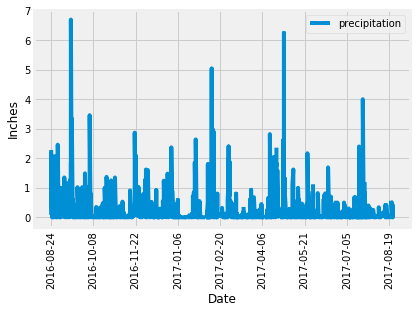

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year before the latest data point in the database
last_date_recorded = session.query(func.max(tbl_measurement.date)).first()[0]
starting_date_for_analysis = month_offset(-12, last_date_recorded)

# Perform a query to retrieve the data and precipitation scores
qry_measurements_last_year_records = session.query(tbl_measurement)\
    .filter(tbl_measurement.date > starting_date_for_analysis)\
    .order_by(tbl_measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df_measurements_last_year_records = \
    pd.read_sql_query(qry_measurements_last_year_records.statement, session.bind)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis=df_measurements_last_year_records.loc[:,"date"]
y_axis=df_measurements_last_year_records.loc[:,"prcp"]

# Plotting the data
fig, ax = plt.subplots()
ax.plot(x_axis, y_axis)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.legend(["precipitation"], loc="upper right")

# Spacing between each grid line
loc = plticker.MultipleLocator(base=45)
ax.xaxis.set_major_locator(loc)
# Rotate x axis ticks
ax.tick_params(axis="x", labelrotation=90)

plt.plot()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_measurements_last_year_records.loc[:,"prcp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [14]:
# Design a query to show how many stations are available in this dataset?
qry_no_stations = session.query(func.count(tbl_station.name)).first()
number_of_distinct_stations=qry_no_stations[0]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
qry_station_activity = session \
    .query(tbl_station.name,func.count(tbl_measurement.id).label('count_id')) \
    .filter(tbl_station.station==tbl_measurement.station) \
    .group_by(tbl_station.name) \
    .order_by(desc('count_id'))
df_station_activity = pd.read_sql_query(qry_station_activity.statement, session.bind)
df_station_activity

,name,count_id
0,"WAIHEE 837.5, HI US",2772
1,"WAIKIKI 717.2, HI US",2724
2,"KANEOHE 838.1, HI US",2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,"MANOA LYON ARBO 785.2, HI US",2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,"PEARL CITY, HI US",1372
8,"UPPER WAHIAWA 874.3, HI US",511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
qry_Waihee_info = session \
    .query(
        tbl_station.name, \
        func.min(tbl_measurement.tobs).label('t_min'), \
        func.avg(tbl_measurement.tobs).label('t_avg'), \
        func.max(tbl_measurement.tobs).label('t_max')) \
    .filter(and_(
        tbl_station.station==tbl_measurement.station, \
        tbl_station.name=="WAIHEE 837.5, HI US")) 
df_Waihee_info = pd.read_sql_query(qry_Waihee_info.statement, session.bind)
df_Waihee_info

,name,t_min,t_avg,t_max
0,"WAIHEE 837.5, HI US",54.0,71.663781,85.0


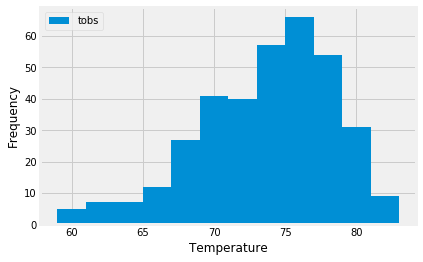

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to get the latest date for Waihee station
qry_Waihee_latest_date = session \
    .query(
        tbl_station.name, \
        tbl_measurement.date) \
    .filter(and_(
        tbl_station.station==tbl_measurement.station, \
        tbl_station.name=="WAIHEE 837.5, HI US")) \
    .order_by(desc(tbl_measurement.date)) \
    .first()[1]
Waihee_latest_date = qry_Waihee_latest_date

# Query to get the last year of data for Waihee station
qry_Waihee_data_to_plot = session \
    .query(
        tbl_measurement.date, \
        tbl_measurement.tobs) \
    .filter(and_(
        tbl_station.station==tbl_measurement.station, \
        tbl_station.name=="WAIHEE 837.5, HI US", \
        tbl_measurement.date>month_offset(-12, Waihee_latest_date))) \
    .order_by(desc(tbl_measurement.date)) 
qry_Waihee_data_to_plot = pd.read_sql_query(qry_Waihee_data_to_plot.statement, session.bind)

#plot the histogram of temperatures for the most active station

fig, ax = plt.subplots()
ax.hist(qry_Waihee_data_to_plot['tobs'], bins=12)
ax.legend(["tobs"], loc="upper left")
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
plt.show()


## Bonus Challenge Assignment

## Temperature analysis I

In [18]:
# Creating a dataframe with the average temperatures in June and December, 
#for all years in the DB

# Define function to extract avg temp for all years for one single month
def avg_temperatures(month):
    qry_avg_temp_june=session \
        .query(extract('year', tbl_measurement.date),func.avg(tbl_measurement.tobs)) \
        .filter(extract('month', tbl_measurement.date)==month) \
        .group_by(extract('year', tbl_measurement.date))
    return pd.read_sql_query(qry_avg_temp_june.statement, session.bind)

#generating dataframe with the data of interest
df_avg_temp=pd.merge(avg_temperatures(6),avg_temperatures(12), on="anon_1")
df_avg_temp=df_avg_temp.rename(columns={"anon_1":"year", "avg_1_x":"AvgT_Jun", "avg_1_y":"AvgT_Dec"})
df_avg_temp

,year,AvgT_Jun,AvgT_Dec
0,2010,74.925620,70.208511
1,2011,73.938326,70.820628
2,2012,74.000000,71.188073
3,2013,74.599078,71.094017
4,2014,75.027907,69.896861
5,2015,74.990148,73.423913
6,2016,75.175258,71.130000


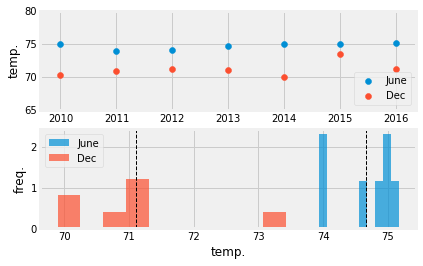

In [19]:
# Plotting the data

# Scatter Plot of Data
fig, ax = plt.subplots(2, 1)
ax[0].scatter(df_avg_temp['year'], df_avg_temp['AvgT_Jun'], label="June")
ax[0].scatter(df_avg_temp['year'], df_avg_temp['AvgT_Dec'], label="Dec")
ax[0].set_xlabel("year")
ax[0].set_ylabel("temp.")
ax[0].set_ylim(65,80)
ax[0].legend(loc="lower right")

# Histogram Plot of Data
ax[1].hist(df_avg_temp['AvgT_Jun'], 10, density=True, alpha=0.7, label="June")
ax[1].hist(df_avg_temp['AvgT_Dec'], 10, density=True, alpha=0.7, label="Dec")
ax[1].axvline(df_avg_temp['AvgT_Jun'].mean(), color='k', linestyle='dashed', linewidth=1)
ax[1].axvline(df_avg_temp['AvgT_Dec'].mean(), color='k', linestyle='dashed', linewidth=1)
ax[1].set_xlabel("temp.")
ax[1].set_ylabel("freq.")
ax[1].legend()  

In [20]:
# two sided T-test without assumption of equal variances  
stats.ttest_ind(df_avg_temp["AvgT_Jun"], df_avg_temp["AvgT_Dec"], equal_var=False)

Ttest_indResult(statistic=7.570096659210406, pvalue=5.3283128862831936e-05)

# Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(tbl_measurement.tobs), func.avg(tbl_measurement.tobs), func.max(tbl_measurement.tobs)).\
        filter(tbl_measurement.date >= start_date).filter(tbl_measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_vacation_date = '2018-01-01'
end_vacation_date = '2018-01-07'

period_before_months = 12
period_start = month_offset(-period_before_months, start_vacation_date)
period_end = month_offset(-period_before_months, end_vacation_date)

temp_of_interest = calc_temps(period_start, period_end)
temp_of_interest

[(62.0, 68.36585365853658, 74.0)]

<ErrorbarContainer object of 3 artists>

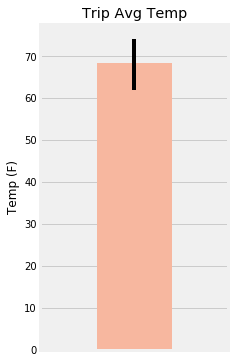

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = 0
y = temp_of_interest[0][1]
upper_error = temp_of_interest[0][2] - temp_of_interest[0][1]
lower_error = temp_of_interest[0][1] - temp_of_interest[0][0]

fig, ax = plt.subplots(1, 1, figsize=(3,6))
ax.bar(x, y, color="#F7B79F")
ax.set_title("Trip Avg Temp")
ax.set_xticks([])
ax.set_ylabel("Temp (F)")
ax.set_xlim(-1,1)
ax.errorbar(x, y, yerr=[[lower_error],[upper_error]], color="black") 


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

qry_station_rainfall = session \
    .query(tbl_station.name,
           tbl_station.elevation,
           tbl_station.latitude,
           tbl_station.longitude,
           func.sum(tbl_measurement.prcp).label('Total_Rainfall')) \
    .filter(and_(tbl_station.station==tbl_measurement.station,
                 tbl_measurement.date>=period_start,
                 tbl_measurement.date<period_end)) \
    .group_by(tbl_station.name) \
    .order_by(desc('Total_Rainfall'))
df_station_rainfall = pd.read_sql_query(qry_station_rainfall.statement, session.bind)
df_station_rainfall

,name,elevation,latitude,longitude,Total_Rainfall
0,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139,0.61
1,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250,0.60
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.52130,-157.83740,0.60
3,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150,0.29
4,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889,0.20
5,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680,0.00


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(tbl_measurement.tobs), func.avg(tbl_measurement.tobs), func.max(tbl_measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", tbl_measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_vacation_date = start_vacation_date #alrealy defined earlier in the code
end_vacation_date = end_vacation_date #alrealy defined earlier earlier in the code

# Use the start and end date to create a range of dates
lst_vacation_dmy = pd.date_range(start=start_vacation_date, end=end_vacation_date)

# Stip off the year and save a list of %m-%d strings
lst_vacation_days = [dt.datetime.strftime(x, '%m-%d') for x in lst_vacation_dmy]

# Loop through the list of %m-%d strings and calculate the normals for each date
lst_daily_normals = [[daily_normals(x)[0][0], \
                      daily_normals(x)[0][1], \
                      daily_normals(x)[0][2]] \
                     for x in lst_vacation_days]

lst_daily_normals = np.transpose(lst_daily_normals)


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_est_temp_for_vacation = \
    pd.DataFrame(zip(lst_vacation_dmy,*lst_daily_normals))
df_est_temp_for_vacation = \
    df_est_temp_for_vacation.rename(columns={
        0: "Day",
        1: "Tmin",
        2: "Tavg",
        3: "Tmax"})
df_est_temp_for_vacation = df_est_temp_for_vacation.set_index("Day")
df_est_temp_for_vacation

,Tmin,Tavg,Tmax
Day,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


Text(0, 0.5, 'Temperature')

<Figure size 1152x1152 with 0 Axes>

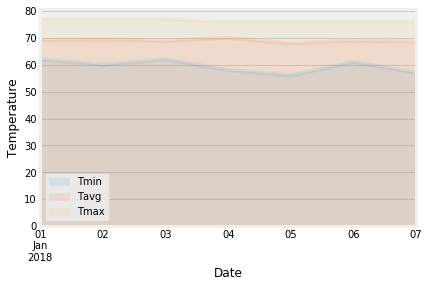

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
fig = plt.figure(figsize=(16,16))
ax = df_est_temp_for_vacation.plot(kind="area", stacked=False, alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("Temperature")

